In [1]:
'''
    Cluster polygon aggregates based on remote sensing and social media inputs 
'''

from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geojson
pd.set_option('display.expand_frame_repr', False)

from shapely import geometry
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import Polygon, mapping
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import shape, Point
from descartes import PolygonPatch
from ast import literal_eval

import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# define functions for analysis 

def fixLstring(row): 
    v = row['combined']
    s = v[1:-1].split(', ')
    s = [np.float(i) for i in s]
    return s

def fixListString(row): 
    s = row['combined']
    s1 = s.replace('array(', '').replace(')', '')
    out = literal_eval(s1)
    return out

def normVec(row): 
    v = row['combined']
    d = np.sum(v)
    norm = [np.float(i)/np.float(d) for i in v]
    return norm

def getAvgVec(row): 
    vecs = np.array(row['input_vec'])
    comb = np.mean(vecs, axis=0)
    return list(comb)

def coercePolygon(row): 
    string = row['polygon'].replace('POLYGON ((', ''). replace('))', '')
    s = string.split(', ')
    s = [i.split(' ') for i in s]
    verts = []
    for i in s: 
        vert = [np.float(v) for v in i]
        vert = tuple(vert)
        verts.append(vert)
    return verts

def concatVecs(row): 
    outvec = [] 
    for v in row['combined_list']: 
        outvec.extend(v)
    return outvec

def mergeValues(row): 
    # ls = row['combined']
    ls = row['normalized_vector']
    ls.append(row['mean_imp'])
    ls.append(row['mean_nl'])
    return ls

def isNanInput(row): 
    i = row['input_vec']
    if type(i) == list: 
        out = 1
    else: 
        out = 0 
    return out


In [3]:
# polygon aggregation based on tesselation (social media & remote sensing)
dhvt = pd.read_csv('../data/day-hour-vectors-RSpoly-100e-som-voronoi.csv')
dhvt['combined_list'] = dhvt.apply(lambda row: fixListString(row), axis=1)
dhvt['combined'] = dhvt.apply(lambda row: concatVecs(row), axis=1)
dhvt['normalized_vector'] = dhvt.apply(lambda row: normVec(row), axis=1)
rst = pd.read_csv('../data/remote-sensing-layers-with-polygon-labels-18-22-100e-som-voronoi.csv')

# polygon aggregation based on regular grid (social media & remote sensing)
dhvr = pd.read_csv('../data/day-hour-vectors-regular-grid.csv')
dhvr['combined'] = dhvr.apply(lambda row: fixListString(row), axis=1)
dhvr['normalized_vector'] = dhvr.apply(lambda row: normVec(row), axis=1)
rsr = pd.read_csv('../data/remote-sensing-data-with-polygon-labels-rectangular-grid.csv')


In [4]:
# merge social media & remote sensing inputs for polygons tesselation & build input vector
inputst = pd.merge(dhvt, rst, on='polygon_id', how='left')
inputst['input_vec'] = inputst.apply(lambda row: mergeValues(row), axis=1)

# merge social media & remote sensing inputs for polygons rectangular & build input vector
inputsr = pd.merge(dhvr, rsr, on='polygon_id', how='left')
inputsr['input_vec'] = inputsr.apply(lambda row: mergeValues(row), axis=1)

In [9]:
# make frame with input vector and polygon id for tesselation
clustert = inputst[['polygon_id', 'input_vec']]
clustert.set_index('polygon_id', inplace=True)
cluster_frame2dt = pd.DataFrame(clustert['input_vec'].values.tolist())

cluster_frame2dt.index.names = ['polygon']
cluster_frame2dt.columns.names = ['time_slot']

# run pricipal components for 2 dimensions for tesselation
pca = PCA(n_components=2)
pca.fit(cluster_frame2dt)
pca_cluster_2dt = pca.transform(cluster_frame2dt)
pca_cluster_2dt = pd.DataFrame(pca_cluster_2dt)
pca_cluster_2dt.index = cluster_frame2dt.index
pca_cluster_2dt.columns = ['PC1','PC2']

# Look at clustering performance week hour for tesselation
# print('Explained variance ratio from PCA')
print('Explained variance ratio from PCA' + str(pca.explained_variance_ratio_))
# [0.98673117 0.01325429] for grid inputs 
# [0.96861452 0.03138379] for tesselation 

# apply kmeans clustering to 2 dimensional coordinates from principal components for tesselation
kmeans = KMeans(n_clusters=5)
clusterst = kmeans.fit(cluster_frame2dt)
pca_cluster_2dt['cluster'] = pd.Series(clusterst.labels_, index=pca_cluster_2dt.index)

# evaluate silouhette scores for kmeans for tesselation
X = np.array(pca_cluster_2dt[['PC1', 'PC2']])
cluster_labelst = kmeans.fit_predict(X)
silhouette_avgt = silhouette_score(X, cluster_labelst)

print('Silhouette average for tesselation clustering: ' + str(silhouette_avgt))

Explained variance ratio from PCA[0.96869672 0.03130161]
Silhouette average for tesselation clustering: 0.4282415048288977


In [10]:
# make frame with input vector and polygon id for grid
clusterr = inputsr[['polygon_id', 'input_vec']]
clusterr.set_index('polygon_id', inplace=True)
cluster_frame2dr = pd.DataFrame(clusterr['input_vec'].values.tolist())

cluster_frame2dr.index.names = ['polygon']
cluster_frame2dr.columns.names = ['time_slot']

# run pricipal components for 2 dimensions for grid
pca = PCA(n_components=2)
pca.fit(cluster_frame2dr)
pca_cluster_2dr = pca.transform(cluster_frame2dr)
pca_cluster_2dr = pd.DataFrame(pca_cluster_2dr)
pca_cluster_2dr.index = cluster_frame2dr.index
pca_cluster_2dr.columns = ['PC1','PC2']

# Look at clustering performance week hour for grid
# print('Explained variance ratio from PCA')
print('Explained variance ratio from PCA' + str(pca.explained_variance_ratio_))
# [0.98673117 0.01325429] for grid inputs 
# [0.96861452 0.03138379] for tesselation 

# apply kmeans clustering to 2 dimensional coordinates from principal components for tesselation
kmeans = KMeans(n_clusters=5)
clustersr = kmeans.fit(cluster_frame2dr)
pca_cluster_2dr['cluster'] = pd.Series(clustersr.labels_, index=pca_cluster_2dr.index)

# evaluate silouhette scores for kmeans for tesselation
X = np.array(pca_cluster_2dr[['PC1', 'PC2']])
cluster_labelsr = kmeans.fit_predict(X)
silhouette_avgr = silhouette_score(X, cluster_labelsr)

print('Silhouette average for tesselation clustering: ' + str(silhouette_avgr))

Explained variance ratio from PCA[0.98673117 0.01325429]
Silhouette average for tesselation clustering: 0.5688825604710074


In [11]:
# build frame for plotting cluster aggregates & coloring clusters
colors = ['yellow', 'red', 'orange', 'blue', 'green']
clrs = []
for i in range(len(colors)): 
    out = {
        'color' : colors[i],
        'cluster' : i
    }
    clrs.append(out)

df_color = pd.DataFrame(clrs)

# add colors to polygon frame based on cluster asignment
df_pcat = pd.merge(pca_cluster_2dt, df_color, on='cluster', how='left')
df_pcat.reset_index(inplace=True)
df_pcat.columns = ['polygon_id', 'PC1', 'PC2', 'cluster', 'color']

# prepare to get average input vectors for all clusters in N 
clustert.reset_index(inplace=True)
df_plott = pd.merge(df_pcat, clustert, on='polygon_id', how='left')
df_plott['is_valid'] = df_plott.apply(lambda row: isNanInput(row), axis=1)
df_plott = df_plott.loc[df_plott['is_valid'] == 1]

df_groupedt = df_plott.groupby('cluster').agg({'input_vec':(lambda x: list(x))})
df_groupedt.reset_index(inplace=True)

# get average vector for each cluster
df_groupedt['avg_vec'] = df_groupedt.apply(lambda row: getAvgVec(row), axis=1)


# get frame of polygons to use for plotting & join to principal components 
polyst = dhvt.groupby('polygon_id').agg({'polygon' : 'max'})
polyst.reset_index(inplace=True)
polyst['pgon'] = polyst.apply(lambda row: coercePolygon(row), axis=1)
df_plot_polyt = pd.merge(df_pcat, polyst, on='polygon_id', how='left')
df_plot_polyt.reset_index(inplace=True)

# make manageable subsets for plotting 
dpgt = df_groupedt[['cluster', 'avg_vec']]
dpgt['sm_vector'] = dpgt.apply(lambda row: row['avg_vec'][:-2], axis=1)
dpgt = dpgt[['cluster', 'sm_vector']]
dpgt.columns = ['cluster', 'avg_vec']

df_plott['mean_nl'] = df_plott.apply(lambda row: row['input_vec'][169], axis=1)
df_plott['mean_imp'] = df_plott.apply(lambda row: row['input_vec'][168], axis=1)

dfgrst = df_plott.groupby('cluster').agg({'mean_nl' : (lambda x: list(x)),
                                        'mean_imp' : (lambda x: list(x))
    })

In [12]:
# repeat above process for grid based clustering
# add colors to polygon frame based on cluster asignment 
df_pcar = pd.merge(pca_cluster_2dr, df_color, on='cluster', how='left')
df_pcar.reset_index(inplace=True)
df_pcar.columns = ['polygon_id', 'PC1', 'PC2', 'cluster', 'color']

# prepare to get average input vectors for all clusters in N 
clusterr.reset_index(inplace=True)
df_plotr = pd.merge(df_pcar, clusterr, on='polygon_id', how='left')
df_plotr['is_valid'] = df_plotr.apply(lambda row: isNanInput(row), axis=1)
df_plotr = df_plotr.loc[df_plotr['is_valid'] == 1]

df_groupedr = df_plotr.groupby('cluster').agg({'input_vec':(lambda x: list(x))})
df_groupedr.reset_index(inplace=True)

# get average vector for each cluster
df_groupedr['avg_vec'] = df_groupedr.apply(lambda row: getAvgVec(row), axis=1)


# get frame of polygons to use for plotting & join to principal components 
polysr = dhvr.groupby('polygon_id').agg({'polygon' : 'max'})
polysr.reset_index(inplace=True)
polysr['pgon'] = polysr.apply(lambda row: coercePolygon(row), axis=1)
df_plot_polyr = pd.merge(df_pcar, polysr, on='polygon_id', how='left')
df_plot_polyr.reset_index(inplace=True)

# make manageable subsets for plotting 
dpgr = df_groupedr[['cluster', 'avg_vec']]
dpgr['sm_vector'] = dpgr.apply(lambda row: row['avg_vec'][:-2], axis=1)
dpgr = dpgr[['cluster', 'sm_vector']]
dpgr.columns = ['cluster', 'avg_vec']

df_plotr['mean_nl'] = df_plotr.apply(lambda row: row['input_vec'][169], axis=1)
df_plotr['mean_imp'] = df_plotr.apply(lambda row: row['input_vec'][168], axis=1)

dfgrsr = df_plotr.groupby('cluster').agg({'mean_nl' : (lambda x: list(x)),
                                        'mean_imp' : (lambda x: list(x))
    })

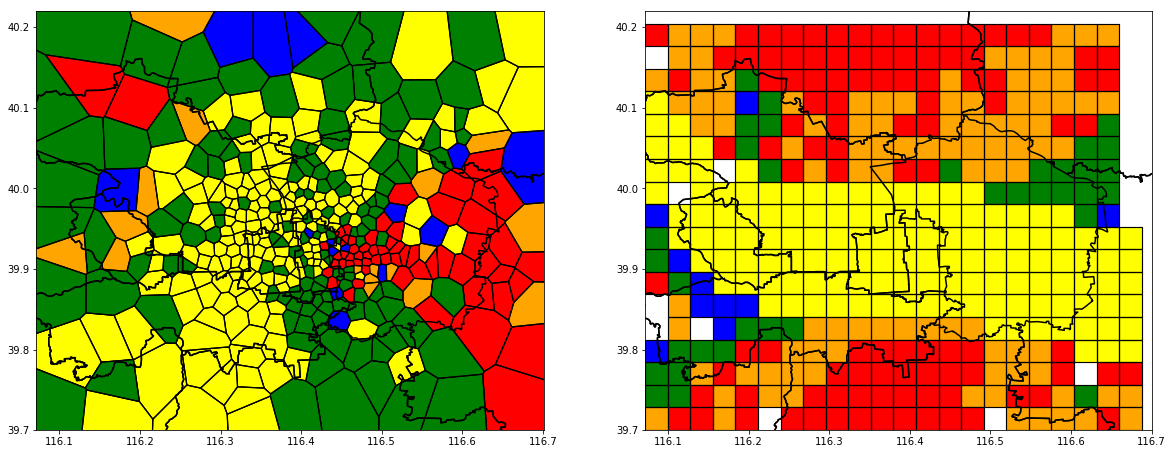

In [13]:
# load geojson of beijing ROI
with open("../data/beijing.geojson") as json_file:
    json_data = geojson.load(json_file)

# make subplots 
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,20))

# Plot geojson polygons
feats = json_data['features']
for i in range(0, len(feats)): 
    try: 
        test = feats[i]
        poly = test['geometry']
        coords = poly['coordinates']
        x = [i for i,j in coords[0]]
        y = [j for i,j in coords[0]]
        # ax = fig.gca() 
        # ax.plot(x,y)
        ax1.plot(x, y, color='black')
        ax1.axis('scaled')
        ax2.plot(x, y, color='black')
        ax2.axis('scaled')
    except: 
        continue

# plot tesselation polygons 
for i in range(len(polyst)): 
    try: 
        verts = df_plot_polyt.iloc[i]['pgon']
        color = df_plot_polyt.iloc[i]['color']
        pList = [Point(i) for i in verts]
        poly = geometry.Polygon([[p.x, p.y] for p in pList])
        x,y = poly.exterior.xy
        ax1.plot(x, y, color='black', alpha=0.7,# color='#6699cc', alpha=0.7,
            linewidth=1.25, solid_capstyle='round', zorder=2)
        ring_mixed = Polygon(verts)
        ring_patch = PolygonPatch(ring_mixed, fc=color)
        ax1.add_patch(ring_patch)
    except: 
        x = 1

# plot grid polygons
for i in range(len(polysr)): 
    try: 
        verts = df_plot_polyr.iloc[i]['pgon']
        color = df_plot_polyr.iloc[i]['color']
        pList = [Point(i) for i in verts]
        poly = geometry.Polygon([[p.x, p.y] for p in pList])
        x,y = poly.exterior.xy
        ax2.plot(x, y, color='black', alpha=0.7,# color='#6699cc', alpha=0.7,
            linewidth=1.25, solid_capstyle='round', zorder=2)
        ring_mixed = Polygon(verts)
        ring_patch = PolygonPatch(ring_mixed, fc=color)
        ax2.add_patch(ring_patch)
    except: 
        x = 1

# Limit axis to focus region
dfWB = pd.read_csv('../data/inLabelRegionPoints.csv')
maxLon, minLon = np.max(dfWB['lon']), np.min(dfWB['lon'])
maxLat, minLat = np.max(dfWB['lat']), np.min(dfWB['lat'])
ax1.set_xlim(minLon, maxLon)
ax1.set_ylim(minLat, maxLat)
ax2.set_xlim(minLon, maxLon)
ax2.set_ylim(minLat, maxLat)

# Reveal plot
plt.show()

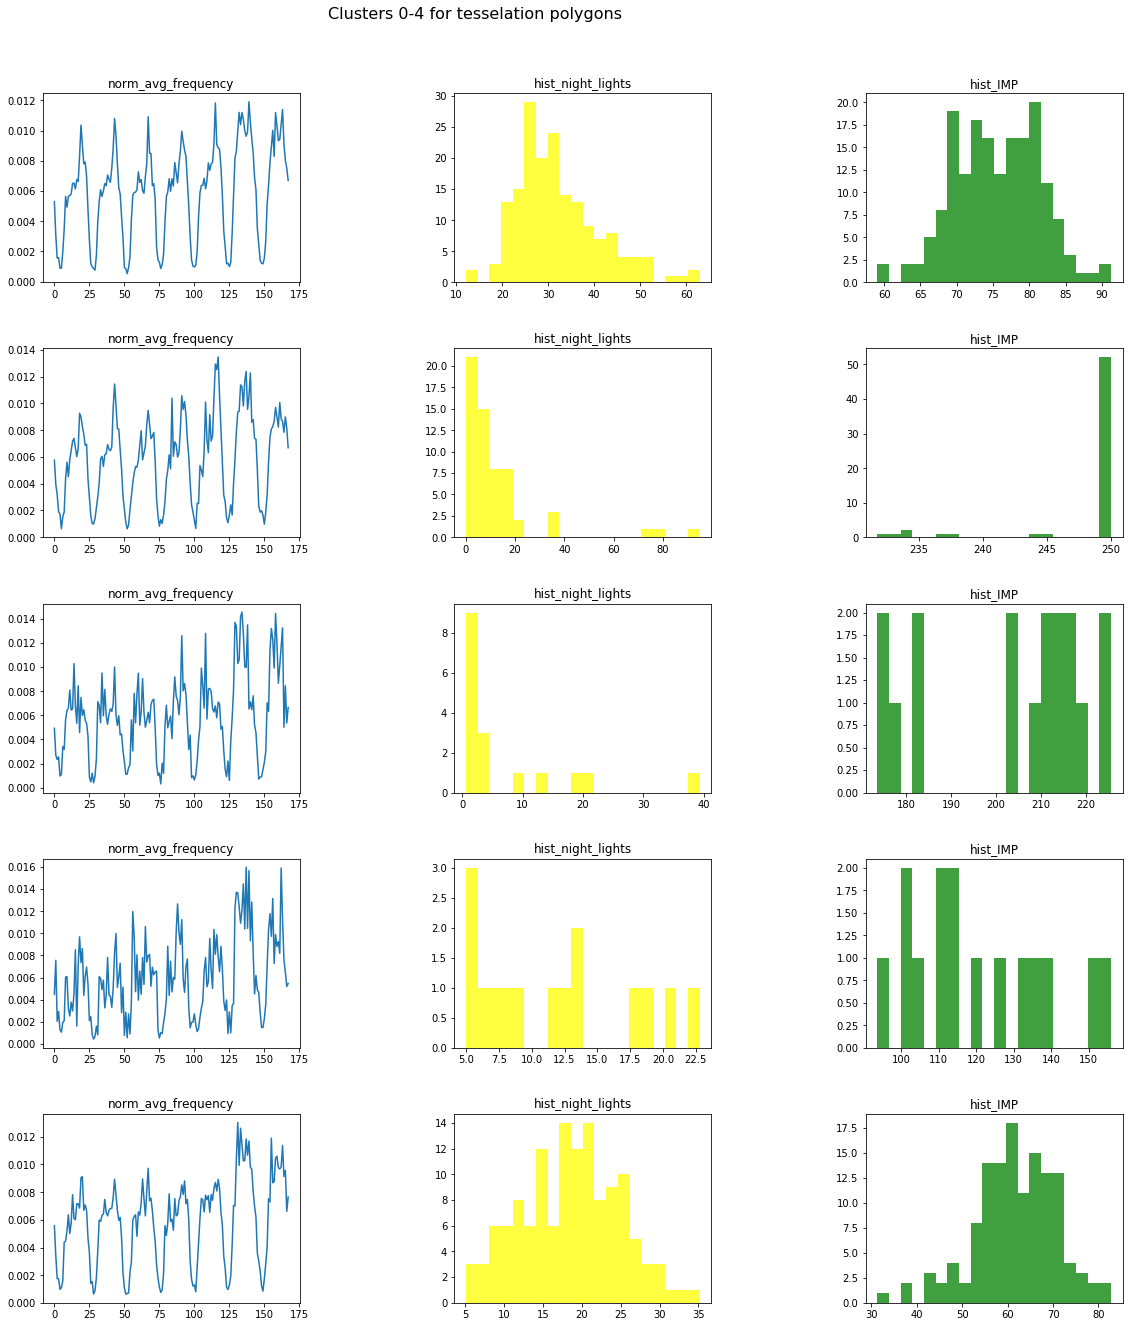

In [24]:
# plot spectral graph for SM activity and distribution of index values for clusters 
# make subplots 
fig, ((ax1,ax2,ax3), (ax4, ax5, ax6), (ax7,ax8,ax9), (ax10,ax11,ax12), (ax13,ax14,ax15)) = plt.subplots(nrows=5, ncols=3, figsize=(20,20))

ax1.plot(dpgt.iloc[0]['avg_vec'])
ax1.set_title('norm_avg_frequency')

xt = np.array(dfgrst.iloc[0]['mean_nl'])
# ax = sns.distplot(x, kde=False)
# plt.hist(x, 20, density=True, facecolor='yellow', alpha=0.75)
ax2.hist(xt, 20, facecolor='yellow', alpha=0.75)
ax2.set_title('hist_night_lights')

x1t = np.array(dfgrst.iloc[0]['mean_imp'])
# plt.hist(x1, 20, density=True, facecolor='green', alpha=0.75)
ax3.hist(x1t, 20, facecolor='green', alpha=0.75)
ax3.set_title('hist_IMP')


ax4.plot(dpgt.iloc[1]['avg_vec'])
ax4.set_title('norm_avg_frequency')

xt = np.array(dfgrst.iloc[1]['mean_nl'])
# ax = sns.distplot(x, kde=False)
# plt.hist(x, 20, density=True, facecolor='yellow', alpha=0.75)
ax5.hist(xt, 20, facecolor='yellow', alpha=0.75)
ax5.set_title('hist_night_lights')

x1t = np.array(dfgrst.iloc[1]['mean_imp'])
# plt.hist(x1, 20, density=True, facecolor='green', alpha=0.75)
ax6.hist(x1t, 20, facecolor='green', alpha=0.75)
ax6.set_title('hist_IMP')


ax7.plot(dpgt.iloc[2]['avg_vec'])
ax7.set_title('norm_avg_frequency')

xt = np.array(dfgrst.iloc[2]['mean_nl'])
# ax = sns.distplot(x, kde=False)
# plt.hist(x, 20, density=True, facecolor='yellow', alpha=0.75)
ax8.hist(xt, 20, facecolor='yellow', alpha=0.75)
ax8.set_title('hist_night_lights')

x1t = np.array(dfgrst.iloc[2]['mean_imp'])
# plt.hist(x1, 20, density=True, facecolor='green', alpha=0.75)
ax9.hist(x1t, 20, facecolor='green', alpha=0.75)
ax9.set_title('hist_IMP')


ax10.plot(dpgt.iloc[3]['avg_vec'])
ax10.set_title('norm_avg_frequency')

xt = np.array(dfgrst.iloc[3]['mean_nl'])
# ax = sns.distplot(x, kde=False)
# plt.hist(x, 20, density=True, facecolor='yellow', alpha=0.75)
ax11.hist(xt, 20, facecolor='yellow', alpha=0.75)
ax11.set_title('hist_night_lights')

x1t = np.array(dfgrst.iloc[3]['mean_imp'])
# plt.hist(x1, 20, density=True, facecolor='green', alpha=0.75)
ax12.hist(x1t, 20, facecolor='green', alpha=0.75)
ax12.set_title('hist_IMP')


ax13.plot(dpgt.iloc[4]['avg_vec'])
ax13.set_title('norm_avg_frequency')

xt = np.array(dfgrst.iloc[4]['mean_nl'])
# ax = sns.distplot(x, kde=False)
# plt.hist(x, 20, density=True, facecolor='yellow', alpha=0.75)
ax14.hist(xt, 20, facecolor='yellow', alpha=0.75)
ax14.set_title('hist_night_lights')

x1t = np.array(dfgrst.iloc[4]['mean_imp'])
# plt.hist(x1, 20, density=True, facecolor='green', alpha=0.75)
ax15.hist(x1t, 20, facecolor='green', alpha=0.75)
ax15.set_title('hist_IMP')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.20, right=0.95, hspace=0.35,
                wspace=0.60)

fig.suptitle('Clusters 0-4 for tesselation polygons', fontsize=16)

plt.show()

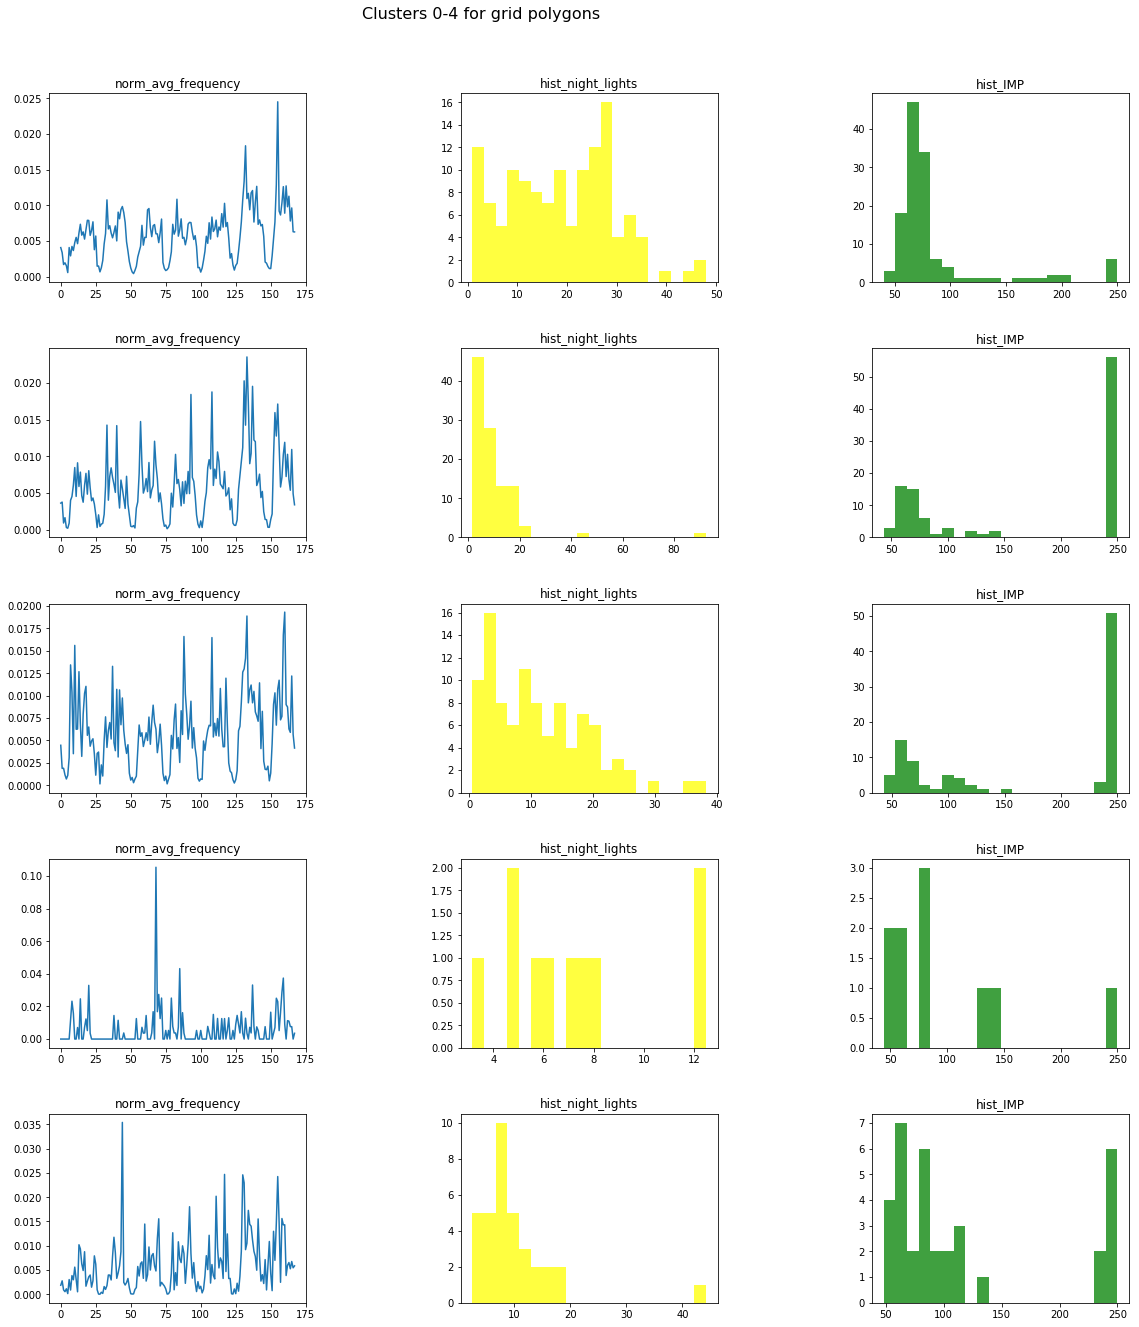

In [25]:
# plot spectral graph for SM activity and distribution of index values for clusters 
# make subplots 
fig, ((ax1,ax2,ax3), (ax4, ax5, ax6), (ax7,ax8,ax9), (ax10,ax11,ax12), (ax13,ax14,ax15)) = plt.subplots(nrows=5, ncols=3, figsize=(20,20))

ax1.plot(dpgr.iloc[0]['avg_vec'])
ax1.set_title('norm_avg_frequency')

xt = np.array(dfgrsr.iloc[0]['mean_nl'])
# ax = sns.distplot(x, kde=False)
# plt.hist(x, 20, density=True, facecolor='yellow', alpha=0.75)
ax2.hist(xt, 20, facecolor='yellow', alpha=0.75)
ax2.set_title('hist_night_lights')

x1t = np.array(dfgrsr.iloc[0]['mean_imp'])
# plt.hist(x1, 20, density=True, facecolor='green', alpha=0.75)
ax3.hist(x1t, 20, facecolor='green', alpha=0.75)
ax3.set_title('hist_IMP')


ax4.plot(dpgr.iloc[1]['avg_vec'])
ax4.set_title('norm_avg_frequency')

xt = np.array(dfgrsr.iloc[1]['mean_nl'])
# ax = sns.distplot(x, kde=False)
# plt.hist(x, 20, density=True, facecolor='yellow', alpha=0.75)
ax5.hist(xt, 20, facecolor='yellow', alpha=0.75)
ax5.set_title('hist_night_lights')

x1t = np.array(dfgrsr.iloc[1]['mean_imp'])
# plt.hist(x1, 20, density=True, facecolor='green', alpha=0.75)
ax6.hist(x1t, 20, facecolor='green', alpha=0.75)
ax6.set_title('hist_IMP')


ax7.plot(dpgr.iloc[2]['avg_vec'])
ax7.set_title('norm_avg_frequency')

xt = np.array(dfgrsr.iloc[2]['mean_nl'])
# ax = sns.distplot(x, kde=False)
# plt.hist(x, 20, density=True, facecolor='yellow', alpha=0.75)
ax8.hist(xt, 20, facecolor='yellow', alpha=0.75)
ax8.set_title('hist_night_lights')

x1t = np.array(dfgrsr.iloc[2]['mean_imp'])
# plt.hist(x1, 20, density=True, facecolor='green', alpha=0.75)
ax9.hist(x1t, 20, facecolor='green', alpha=0.75)
ax9.set_title('hist_IMP')


ax10.plot(dpgr.iloc[3]['avg_vec'])
ax10.set_title('norm_avg_frequency')

xt = np.array(dfgrsr.iloc[3]['mean_nl'])
# ax = sns.distplot(x, kde=False)
# plt.hist(x, 20, density=True, facecolor='yellow', alpha=0.75)
ax11.hist(xt, 20, facecolor='yellow', alpha=0.75)
ax11.set_title('hist_night_lights')

x1t = np.array(dfgrsr.iloc[3]['mean_imp'])
# plt.hist(x1, 20, density=True, facecolor='green', alpha=0.75)
ax12.hist(x1t, 20, facecolor='green', alpha=0.75)
ax12.set_title('hist_IMP')


ax13.plot(dpgr.iloc[4]['avg_vec'])
ax13.set_title('norm_avg_frequency')

xt = np.array(dfgrsr.iloc[4]['mean_nl'])
# ax = sns.distplot(x, kde=False)
# plt.hist(x, 20, density=True, facecolor='yellow', alpha=0.75)
ax14.hist(xt, 20, facecolor='yellow', alpha=0.75)
ax14.set_title('hist_night_lights')

x1t = np.array(dfgrsr.iloc[4]['mean_imp'])
# plt.hist(x1, 20, density=True, facecolor='green', alpha=0.75)
ax15.hist(x1t, 20, facecolor='green', alpha=0.75)
ax15.set_title('hist_IMP')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.20, right=0.95, hspace=0.35,
                wspace=0.60)

fig.suptitle('Clusters 0-4 for grid polygons', fontsize=16)

plt.show()